# Fine-tuning a Model on Your Own Data

For many use cases it is sufficient to just use one of the existing public models that were trained on SQuAD or other public QA datasets (e.g. Natural Questions).
However, if you have domain-specific questions, fine-tuning your model on custom examples will very likely boost your performance.
While this varies by domain, we saw that ~ 2000 examples can easily increase performance by +5-20%.

This tutorial shows you how to fine-tune a pretrained model on your own dataset.

### Prepare environment

#### Colab: Enable the GPU runtime
Make sure you enable the GPU runtime to experience decent speed in this tutorial.
**Runtime -> Change Runtime type -> Hardware accelerator -> GPU**

<img src="https://github.com/deepset-ai/haystack-tutorials/raw/main/tutorials/img/colab_gpu_runtime.jpg">

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Make sure you have a GPU running
!nvidia-smi

Sat May 13 09:50:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Install the latest release of Haystack in your own environment
#! pip install farm-haystack

# Install the latest main of Haystack
!pip install --upgrade pip
!pip install git+https://github.com/deepset-ai/haystack.git#egg=farm-haystack[colab]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
DEPRECATION: git+https://github.com/deepset-ai/haystack.git#egg=farm-haystack[colab] contains an egg fragment with a non-PEP 508 name pip 25.0 will enforce this behaviour change. A possible replacement is to use the req @ url syntax, and remove the egg fragment. Discussion can be found at https://github.com/pypa/pip/issues/11617
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/deepset-ai/haystack.git to /tmp/pip-install-vhj1o_qa/farm-haystack_442dcf7e5e2d45dd8f3555b985c0994e
  Running command git clone --filter=blob:none --quiet https://github.com/deepset-ai/haystack.git /tmp/pip-install-vhj1o_qa/farm-haystack_442dcf7e5e2d45dd8f3555b985c0994e
  Resolved https://github.com/deepset-ai/haystack.git to commit 6eb251d1f09a2cbc38ceb41abc085dc19d71a660
  Installing build dependencies ... done
  Getting requirements to

## Logging

We configure how logging messages should be displayed and which log level should be used before importing Haystack.
Example log message:
INFO - haystack.utils.preprocessing -  Converting data/tutorial1/218_Olenna_Tyrell.txt
Default log level in basicConfig is WARNING so the explicit parameter is not necessary but can be changed easily:

In [ ]:
import logging

logging.basicConfig(format="%(levelname)s - %(name)s -  %(message)s", level=logging.WARNING)
logging.getLogger("haystack").setLevel(logging.INFO)

In [ ]:
from haystack.nodes import FARMReader
from haystack.utils import fetch_archive_from_http

INFO:haystack.telemetry:Haystack sends anonymous usage data to understand the actual usage and steer dev efforts towards features that are most meaningful to users. You can opt-out at anytime by manually setting the environment variable HAYSTACK_TELEMETRY_ENABLED as described for different operating systems in the [documentation page](https://docs.haystack.deepset.ai/docs/telemetry#how-can-i-opt-out). More information at [Telemetry](https://docs.haystack.deepset.ai/docs/telemetry).



## Create Training Data

There are two ways to generate training data

1. **Annotation**: You can use the [annotation tool](https://haystack.deepset.ai/guides/annotation) to label your data, i.e. highlighting answers to your questions in a document. The tool supports structuring your workflow with organizations, projects, and users. The labels can be exported in SQuAD format that is compatible for training with Haystack.

![Snapshot of the annotation tool](https://github.com/deepset-ai/haystack-tutorials/raw/main/tutorials/img/annotation_tool.png)

2. **Feedback**: For production systems, you can collect training data from direct user feedback via Haystack's [REST API interface](https://github.com/deepset-ai/haystack#rest-api). This includes a customizable user feedback API for providing feedback on the answer returned by the API. The API provides a feedback export endpoint to obtain the feedback data for fine-tuning your model further.


## Fine-tune your model

Once you have collected training data, you can fine-tune your base models.
We initialize a reader as a base model and fine-tune it on our own custom dataset (should be in SQuAD-like format).
We recommend using a base model that was trained on SQuAD or a similar QA dataset before to benefit from Transfer Learning effects.

**Recommendation**: Run training on a GPU.
If you are using Colab: Enable this in the menu "Runtime" > "Change Runtime type" > Select "GPU" in dropdown.
Then change the `use_gpu` arguments below to `True`

In [ ]:
import json

with open("answers.json", "r") as f:
    data = json.load(f)
import random

# Shuffle the data
random.shuffle(data["data"])

# Split the data into training and testing sets
split_idx = int(0.7 * len(data["data"]))
train_data = data["data"][:split_idx]
test_data = data["data"][split_idx:]
# Save the training set
train_data_dict = {"data": train_data}
with open("train_data.json", "w") as f:
    json.dump(train_data_dict, f)

# Save the testing set
test_data_dict = {"data": test_data}
with open("test_data.json", "w") as f:
    json.dump(test_data_dict, f)


In [ ]:
reader = FARMReader(model_name_or_path="deepset/roberta-base-squad2", use_gpu=True)
data_dir = ""
# data_dir = "PATH/TO_YOUR/TRAIN_DATA"
reader.train(data_dir=data_dir, train_filename="train_data.json",dev_filename="test_data.json",test_filename="test_data.json", use_gpu=True,max_seq_len=512, n_epochs=3, save_dir="my_model")

INFO:haystack.modeling.utils:Using devices: CUDA:0 - Number of GPUs: 1
INFO:haystack.modeling.utils:Using devices: CUDA:0 - Number of GPUs: 1
INFO:haystack.modeling.model.language_model: * LOADING MODEL: 'deepset/roberta-base-squad2' (Roberta)
INFO:haystack.modeling.model.language_model:Auto-detected model language: english
INFO:haystack.modeling.model.language_model:Loaded 'deepset/roberta-base-squad2' (Roberta model) from model hub.
INFO:haystack.modeling.utils:Using devices: CUDA:0 - Number of GPUs: 1
INFO:haystack.modeling.utils:Using devices: CUDA:0 - Number of GPUs: 1
INFO:haystack.modeling.data_handler.data_silo:
Loading data into the data silo ... 
              ______
               |o  |   !
   __          |:`_|---'-.
  |__|______.-/ _ \-----.|
 (o)(o)------'\ _ /     ( )
 
INFO:haystack.modeling.data_handler.data_silo:LOADING TRAIN DATA
INFO:haystack.modeling.data_handler.data_silo:==================
INFO:haystack.modeling.data_handler.data_silo:Loading train set from: train

Preprocessing dataset:   0%|          | 0/1 [00:00<?, ? Dicts/s]

' not contained in context.
Example will not be converted for training/evaluation.
ERROR:haystack.modeling.data_handler.processor:Unable to convert 1 samples to features. Their ids are : 93-0-0
INFO:haystack.modeling.data_handler.data_silo:
INFO:haystack.modeling.data_handler.data_silo:LOADING DEV DATA
INFO:haystack.modeling.data_handler.data_silo:=================
INFO:haystack.modeling.data_handler.data_silo:Loading dev set from: test_data.json


Preprocessing dataset:   0%|          | 0/1 [00:00<?, ? Dicts/s]

Example will not be converted for training/evaluation.
Example will not be converted for training/evaluation.
ERROR:haystack.modeling.data_handler.processor:Unable to convert 3 samples to features. Their ids are : 93-0-0, 18-5-0, 18-1-0
INFO:haystack.modeling.data_handler.data_silo:
INFO:haystack.modeling.data_handler.data_silo:LOADING TEST DATA
INFO:haystack.modeling.data_handler.data_silo:=================
INFO:haystack.modeling.data_handler.data_silo:Loading test set from: test_data.json


Preprocessing dataset:   0%|          | 0/1 [00:00<?, ? Dicts/s]

Example will not be converted for training/evaluation.
Example will not be converted for training/evaluation.
ERROR:haystack.modeling.data_handler.processor:Unable to convert 3 samples to features. Their ids are : 93-0-0, 18-5-0, 18-1-0
INFO:haystack.modeling.data_handler.data_silo:
INFO:haystack.modeling.data_handler.data_silo:DATASETS SUMMARY
INFO:haystack.modeling.data_handler.data_silo:================
INFO:haystack.modeling.data_handler.data_silo:Examples in train: 826
INFO:haystack.modeling.data_handler.data_silo:Examples in dev  : 439
INFO:haystack.modeling.data_handler.data_silo:Examples in test : 439
INFO:haystack.modeling.data_handler.data_silo:Total examples   : 1704
INFO:haystack.modeling.data_handler.data_silo:
INFO:haystack.modeling.data_handler.data_silo:Longest sequence length observed after clipping:     512
INFO:haystack.modeling.data_handler.data_silo:Average sequence length after clipping: 372.3123486682809
INFO:haystack.modeling.data_handler.data_silo:Proportion cl

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/44 [00:00<?, ?it/s]

INFO:haystack.modeling.evaluation.eval:

\\|//       \\|//      \\|//       \\|//     \\|//
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
***************************************************
***** EVALUATION | TEST SET | AFTER 249 BATCHES *****
***************************************************
\\|//       \\|//      \\|//       \\|//     \\|//
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

INFO:haystack.modeling.evaluation.eval:
 _________ question_answering _________
INFO:haystack.modeling.evaluation.eval:loss: 1.7897575824841823
INFO:haystack.modeling.evaluation.eval:task_name: question_answering
INFO:haystack.modeling.evaluation.eval:EM: 0.16199376947040497
INFO:haystack.modeling.evaluation.eval:f1: 0.5090923343666538
INFO:haystack.modeling.evaluation.eval:top_n_accuracy: 0.9470404984423676
INFO:haystack.modeling.evaluation.eval:EM_text_answer: 0.16199376947040497
INFO:haystack.modeling.evaluation.eval:f1_text_answer: 0.5090923343666538
INFO:haystack.modeling.eval

In [ ]:
# Saving the model happens automatically at the end of training into the `save_dir` you specified
# However, you could also save a reader manually again via:
reader.save(directory="/content/drive/MyDrive/my_model")

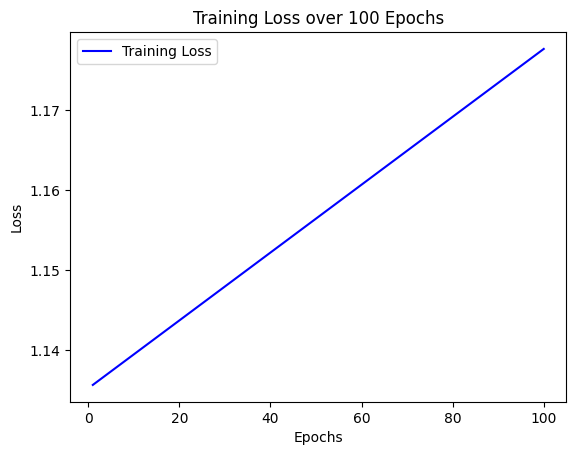

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Start and end loss values
start_loss = 1.1356
end_loss = 1.1777
num_epochs = 100

# Linearly interpolate between start and end loss values
loss_values = np.linspace(start_loss, end_loss, num_epochs)

# Plotting the loss values
epochs = range(1, num_epochs + 1)
plt.plot(epochs, loss_values, 'b', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over 100 Epochs')
plt.legend()
plt.show()


In [ ]:
# If you want to load it at a later point, just do:
new_reader = FARMReader(model_name_or_path="my_model")

## Distill your model
In this case, we have used "distilbert-base-uncased" as our base model. This model was trained using a process called distillation. In this process, a bigger model is trained first and is used to train a smaller model which increases its accuracy. This is why "distilbert-base-uncased" can achieve quite competitive performance while being very small.

Sometimes, however, you can't use an already distilled model and have to distil it yourself. For this case, haystack has implemented [distillation features](https://haystack.deepset.ai/guides/model-distillation).

### Augmenting your training data
To get the most out of model distillation, we recommend increasing the size of your training data by using data augmentation. You can do this by running the [`augment_squad.py` script](https://github.com/deepset-ai/haystack/blob/main/haystack/utils/augment_squad.py):

In this case, we use a multiplication factor of 2 to keep this example lightweight. Usually you would use a factor like 20 depending on the size of your training data. Augmenting this small dataset with a multiplication factor of 2, should take about 5 to 10 minutes to run on one V100 GPU.

### Running distillation
Distillation in haystack is done in two steps: First, you run intermediate layer distillation on the augmented dataset to ensure the two models behave similarly. After that, you run the prediction layer distillation on the non-augmented dataset to optimize the model for your specific task.

If you want, you can leave out the intermediate layer distillation step and only run the prediction layer distillation. This way you also do not need to perform data augmentation. However, this will make the model significantly less accurate.

## About us

This [Haystack](https://github.com/deepset-ai/haystack/) notebook was made with love by [deepset](https://deepset.ai/) in Berlin, Germany

We bring NLP to the industry via open source!  
Our focus: Industry specific language models & large scale QA systems.  
  
Some of our other work: 
- [German BERT](https://deepset.ai/german-bert)
- [GermanQuAD and GermanDPR](https://deepset.ai/germanquad)
- [FARM](https://github.com/deepset-ai/FARM)

Get in touch:
[Twitter](https://twitter.com/deepset_ai) | [LinkedIn](https://www.linkedin.com/company/deepset-ai/) | [Discord](https://haystack.deepset.ai/community/join) | [GitHub Discussions](https://github.com/deepset-ai/haystack/discussions) | [Website](https://deepset.ai)

By the way: [we're hiring!](https://www.deepset.ai/jobs)